In [1]:
# Fix `from_passive_LTIModel`
# Add calls to contract() for J,R,G,P

from pymor.models.iosys import PHLTIModel
from pymor.operators.constructions import (
    InverseOperator,
    VectorArrayOperator
)
from pymor.algorithms.simplify import contract

def from_passive_LTIModel(model):
    # Determine solution of KYP inequality
    L = VectorArrayOperator(model.gramian('pr_o_lrcf'), adjoint=True)
    X = L.H @ L

    Q = X
    E = model.E
    J = contract(0.5 * (model.A @ InverseOperator(X) - InverseOperator(X) @ model.A.H))
    R = contract(-0.5 * (model.A @ InverseOperator(X) + InverseOperator(X) @ model.A.H))
    G = contract(0.5 * (InverseOperator(X) @ model.C.H + model.B))
    P = contract(0.5 * (InverseOperator(X) @ model.C.H - model.B))
    S = 0.5 * (model.D + model.D.H)
    N = 0.5 * (model.D - model.D.H)

    return PHLTIModel(E=E, J=J, R=R, G=G, P=P, S=S, N=N, Q=Q, solver_options=model.solver_options,
               error_estimator=model.error_estimator, visualizer=model.visualizer, name=model.name)

PHLTIModel.from_passive_LTIModel = from_passive_LTIModel

# LTI systems

$$
\begin{align}
E\dot{x}(t) &= Ax(t) + Bu(t) \tag{LTI1} \\
y(t) &= Cx(t) + Du(t) \tag{LTI2}
\end{align}
$$

with matrices

$$
\begin{align*}
  E, A \in \mathbb{R}^{n,n}, \qquad
  B \in \mathbb{R}^{n,m}, \qquad
  C \in \mathbb{R}^{m,n}, \quad\text{and}\quad
  D \in \mathbb{R}^{m,m}.
\end{align*}
$$

Here,

- $x(t) \in \mathbb{R}^n$ is called the *state*,
- $u(t) \in \mathbb{R}^m$ is called the *input*,
- $y(t) \in \mathbb{R}^m$ is called the *output*.

We denote the system by $\Sigma = (E,A,B,C,D)$.

Transfer function $G(s) := C(sE-A)^{-1}B+D$.

# Assumptions

- Only continuous-time systems,
- $E$ nonsingular (no differential-algebraic systems),
- No parameter dependencies,
- No non-linearities.

# Caveats

Currently, at several places dense solvers/algorithms are involved copying all data to numpy.

For example, currently, computation of positive-real Gramians might call dense solvers, despite of `_lrcf` suffix. 

# Port-Hamiltonian systems

Structured LTI system

$$
\begin{align}
    E \dot{x}(t) & = (J - R) Q x(t) + (G-P) u(t),\\
    y(t) & = (G+P)^T Q x(t) + (S-N) u(t)
\end{align}
$$

$$
E,J,R,Q \in \mathbb{R}^{n,n}, \qquad
G,P \in \mathbb{R}^{n,m},
\qquad S,N \in \mathbb{R}^{m,m}
$$

$$
\text{Let} \quad H := Q^T E, \qquad
\text{structure matrix}\ \Gamma :=
\begin{bmatrix}
    J & G \\
    -G^T & N
\end{bmatrix}, \qquad
\text{dissipation matrix}\ \mathcal{W} :=
\begin{bmatrix}
    R & P \\
    P^T & S
\end{bmatrix}.
$$

The LTI system is *port-Hamiltonian* if it holds:

$$
H = H^T \succ 0, \quad
\Gamma^T = -\Gamma \quad \text{and} \quad
\mathcal{W} = \mathcal{W}^T \succcurlyeq 0.
$$

energy function/Hamiltonian $\mathcal{H}(x) := \tfrac{1}{2} x^T H x$

# Simple example: RLC circuit

<img style="float: left;" src="rlc_circuit.svg" width="60%">

# Simple example: RLC circuit

Circuit equations:

$$
\begin{aligned}
    U - U_\mathcal{R} - U_L - U_C &= 0,\\
    U_\mathcal{R} &= \mathcal{R} \mathcal{I}, \quad
    U_L = L\dot{\mathcal{I}}\\
    \mathcal{I} &= C\dot{U}_C.
\end{aligned}
$$

Insert the second and third equation into the first equation:

$$
\begin{align*}
    L\dot{\mathcal{I}}&=U-\mathcal{R} \mathcal{I}-U_C\\
    \mathcal{I}&=C\dot{U}_C
\end{align*}
$$

Write in matrix form and amend an output equation:

$$
\begin{align}
    \begin{bmatrix}
        C&0\\0&L
    \end{bmatrix} \begin{bmatrix}
        \dot{U}_C\\\dot{\mathcal{I}}
    \end{bmatrix} &= \begin{bmatrix}
        0&1\\-1&-\mathcal{R}
    \end{bmatrix} \begin{bmatrix}
        U_C\\\mathcal{I}
    \end{bmatrix} + \begin{bmatrix}
        0\\1
    \end{bmatrix} U \\
    \mathcal{I} &= \begin{bmatrix}
        0&1
    \end{bmatrix} \begin{bmatrix}
        U_C\\\mathcal{I}
    \end{bmatrix}
\end{align}
$$

Note: 
- The product of the output and
input $IU$ corresponds to the electrical power supplied to the circuit.
- The Hamiltonian $H = \frac{1}{2} CU_C^2 + \frac{1}{2} L\mathcal{I}^2$ corresponds to the energy
stored in the circuit by the capacitance and inductance.

# More system-theoretic properties

### Passive

We call an LTI system *passive*, if there
exists a matrix $Q$ with $Q^TE = E^TQ$, such that for all $x_0 \in \mathbb{R}^n$ and trajectories
$(x,u,y)$ satisfying $\mathrm{(LTI1,LTI2)}$, the function
$S(x) := \frac{1}{2} x^T Q^TE x$, called the
*storage function*, satisfies

$$
S(x(T)) - S(x(0)) \leq \int_0^T y(s)^Tu(s)\ \mathrm{d}s
\quad \text{and} \quad
S(x(T)) \geq 0 \quad \text{for all $T\geq 0$}.
$$

### Positive-real

We call an LTI system *positive real*,
if its transfer function $G$ has no poles in $\mathbb{C}^+$, i.e. the system is
stable, and if $G(s) + (G(s))^H \geq 0$ for all $s \in \mathbb{C}^+$.

# More system-theoretic properties

### KYP-LMI

An LTI system has a solution to the *KYP-LMI* if there exists a matrix $X \in \mathbb{R}^{n,n}$ satisfying

$$
\mathcal{W}_E(X) := \begin{bmatrix}
    -A^TXE-E^TXA&C^T-E^TXB\\
    C-B^TXE&D+D^T
\end{bmatrix} \geq 0 \quad
\text{and} \quad X=X^T > 0.
\tag{KYP}
$$

If an LTI system is minimal, the following are equivalent:

- The system is port-Hamiltonian;
- The system is passive;
- The system is positive-real;
- There exists a matrix $X$ satisfying the KYP-LMI.

Furthermore:

A matrix $X$ satisfying the KYP-LMI gives a $Q$ for a port-Hamiltonian representation (and vice-versa).

### Riccati equation

If $(D + D^T)^{-1}$ is invertible, a solution to the *Riccati equation*

$$
A^T X E + E^T X A + (C^T - E^T X B) (D + D^T)^{-1} (C - B^T X E) = 0, \quad X=X^T
$$

is also a solution to the KYP-LMI (use Schur-Complement).

It is known that there exist symmetric matrices $X_\mathrm{min}$ and $X_\mathrm{max}$ such that the symmetric solutions of  the Riccati equation are bounded in the sense of

$$
X_\mathrm{min} \leq X \leq X_\mathrm{max}.
$$

If LTI system is minimal and passive, then $0 < X_\mathrm{min}$.

# Slycot

Dense matrix equation solvers for system-theoretic methods and H-infinity norm calculation (requires OpenBLAS headers and a Fortran compiler)

```
$ pip install slycot
```

# A toy problem: Mass-spring-damper chain

<img style="float: left;" src="msd_example.svg" width="70%">

The inputs $u_1$ and $u_2$ are the external forces on the first two
masses $m_1$ and $m_2$.

The system outputs $y_1$ and $y_2$
correspond to the velocities of the first two masses $m_1$ and $m_2$.

Here, for $i=1,\dots,n/2$:
- spring constants $k_i$,
- damping constants $c_i$.

In [2]:
import numpy as np
from pymor.models.iosys import PHLTIModel
from pymordemos.phlti import msd

J, R, G, P, S, N, E, Q = msd(50, 2)

# tolerance for solving the Riccati equation instead of KYP-LMI
# by introducing a regularization feedthrough term D
# (required for PRBTReductor and SpectralFactorReductor reductors)
S += np.eye(S.shape[0]) * 1e-12

fom = PHLTIModel.from_matrices(J, R, G, P=P, S=S, N=N, E=E, Q=Q, solver_options={'ricc_pos_lrcf': 'slycot'})

In [3]:
print(fom)

PHLTIModel
    class: PHLTIModel
    number of equations: 50
    number of inputs:    2
    number of outputs:   2
    continuous-time
    port-Hamiltonian
    linear time-invariant
    solution_space:  NumpyVectorSpace(50, id='STATE')


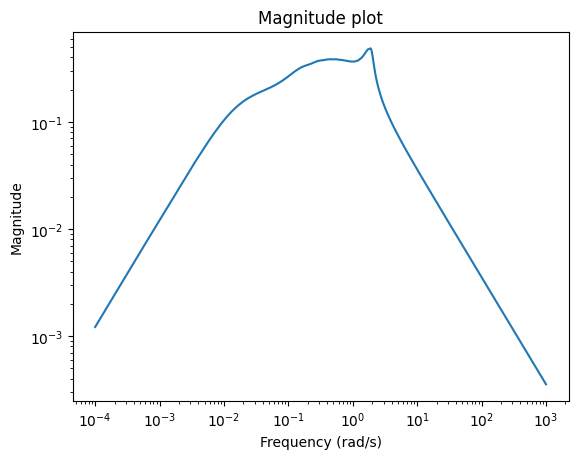

In [4]:
w = (1e-4, 1e3)
_ = fom.transfer_function.mag_plot(w)

In [5]:
from pymor.models.iosys import LTIModel
isinstance(fom, LTIModel) # PHLTIModel inherits from LTIModel

True

# Structure-preserving MOR

**Goal**: Preserve the port-Hamiltonian structure, i.e., compute a ROM that is also port-Hamiltonian.

We have a look at:

- pH-IRKA ([`PHIRKAReductor`](https://docs.pymor.org/2023-1-0/autoapi/pymor/reductors/ph/ph_irka/index.html#pymor.reductors.ph.ph_irka.PHIRKAReductor)) [GPBvandSchaft12],
- PRBT ([`PRBTReductor`](https://docs.pymor.org/2023-1-0/autoapi/pymor/reductors/bt/index.html#pymor.reductors.bt.PRBTReductor)) [DP84, GA04, HJS84],
- passivity preserving model reduction via spectral factorization
  ([`SpectralFactorReductor`](https://docs.pymor.org/2023-1-0/autoapi/pymor/reductors/spectral_factor/index.html#pymor.reductors.spectral_factor.SpectralFactorReductor)) [BU22].

# pH-IRKA [GPBvandSchaft12]

**Projection-based MOR $V,W \in \mathbb{R}^{n,r}$:**

$$
\begin{align}
    \underbrace{(W^T E V)}_{= \hat{E}} \dot{\hat{x}} &=
    \underbrace{(W^TAV)}_{= \hat{A}}\hat{x}
    + \underbrace{(W^TB)}_{= \hat{B}}u \\
    y &= \underbrace{(CV)}_{= \hat{C}}\hat{x}
    + \underbrace{D}_{= \hat{D}}u
\end{align}
$$

The IRKA fixed-point iteration is performed,
but the left projection matrix is chosen as $W := QV$.
This yields a pH ROM with:

- $\hat{E} = W^TEV= V^TQ^TEV$,
- $\hat{Q} = I$,
- $\hat{A} = W^TAV = W^T (J-R) QV =
\underbrace{V^T Q^TJ QV}_{=\hat{J}} - \underbrace{V^TQ^T R QV}_{=\hat{R}}$,
- $\hat{B} = W^TB = W^T(G-P) = \underbrace{V^TQ^TG}_{=\hat{G}} - \underbrace{V^TQ^TP}_{=\hat{P}}$,
- $\hat{C} = CV = (G+P)^TQV = \underbrace{G^TQV}_{=\hat{G}^T} + \underbrace{P^TQV}_{=\hat{P}^T}$,
- $\hat{S} = S$ and $\hat{N} = N$.

In [6]:
from pymor.reductors.ph.ph_irka import PHIRKAReductor

reductor = PHIRKAReductor(fom)
rom1 = reductor.reduce(10)

00:00 PHIRKAReductor: Generating initial interpolation data
00:00 PHIRKAReductor: Starting pH-IRKA
00:00 gram_schmidt: Orthonormalizing vector 2 again
00:00 gram_schmidt: Orthonormalizing vector 3 again
00:00 gram_schmidt: Orthonormalizing vector 4 again
00:00 gram_schmidt: Orthonormalizing vector 5 again
00:00 gram_schmidt: Orthonormalizing vector 6 again
00:00 gram_schmidt: Orthonormalizing vector 7 again
00:00 gram_schmidt: Orthonormalizing vector 8 again
00:00 gram_schmidt: Orthonormalizing vector 9 again
00:00 PHLTIPGReductor: Operator projection ...
00:00 PHLTIPGReductor: Building ROM ...
00:00 PHIRKAReductor: Convergence criterion in iteration 1: 1.808009e+01
00:00 gram_schmidt: Orthonormalizing vector 2 again
00:00 gram_schmidt: Orthonormalizing vector 3 again
00:00 gram_schmidt: Orthonormalizing vector 4 again
00:00 gram_schmidt: Orthonormalizing vector 5 again
00:00 gram_schmidt: Orthonormalizing vector 6 again
00:00 gram_schmidt: Orthonormalizing vector 7 again
00:00 gram_sc

In [7]:
print(f'rom1 is of type {type(rom1)}.')

rom1 is of type <class 'pymor.models.iosys.PHLTIModel'>.


# Positive-real balanced truncation (PRBT) [DP84, GA04, HJS84]

Same procedure as standard BT, but different Gramians:

**positive-real observability Gramian $X$:**

minimal solution to $A^T X E + E^T X A + (C^T - E^T X B) (D + D^T)^{-1} (C - B^T X E) = 0$, $X=X^T$.

**positive-real controllability Gramian $Y$:**

minimal solution to $A Y E^T + E Y A^T +(B^T − E Y C^T)(D+D^T)^{−1}(B − CYE^T)=0$, $Y=Y^T$.

The resulting ROM is positive-real (and hence passive).

In [8]:
fom.gramian('pr_o_lrcf')

NumpyVectorArray(
    NumpyVectorSpace(50, id='STATE'),
    [[-1.73828010e+00 -1.03207228e-12  2.46765814e+00 ... -2.34823074e-05
      -1.62244243e-05 -1.15465801e-05]
     [ 8.74090520e-01 -2.33895035e-12  1.43477376e-01 ...  1.91242514e-05
       1.33676482e-05  9.39988437e-06]
     [-3.28862689e-01  2.26670446e-12 -2.20914472e-01 ...  1.23290922e-05
       8.35734764e-06  6.06848600e-06]
     ...
     [-4.16697145e-18  4.64273824e-21 -1.21648005e-17 ...  1.63561389e-06
       5.13932195e-08 -9.52372664e-07]
     [-9.76489579e-21 -1.10101183e-22 -1.27365655e-20 ... -1.87584473e-07
      -2.21481596e-08  1.06135840e-07]
     [ 4.38352919e-20  1.89353712e-22  9.50258242e-20 ...  9.96439362e-08
      -3.16501217e-09 -5.08355647e-08]],
    _len=50)

In [9]:
from pymor.reductors.bt import PRBTReductor

reductor = PRBTReductor(fom)
rom2 = reductor.reduce(10)

00:01 gram_schmidt: Orthonormalizing vector 3 again
00:01 gram_schmidt: Orthonormalizing vector 4 again
00:01 gram_schmidt: Orthonormalizing vector 5 again
00:01 gram_schmidt: Orthonormalizing vector 6 again
00:01 gram_schmidt: Orthonormalizing vector 7 again
00:01 gram_schmidt: Orthonormalizing vector 8 again
00:01 gram_schmidt: Orthonormalizing vector 9 again
00:01 gram_schmidt: Orthonormalizing vector 3 again
00:01 gram_schmidt: Orthonormalizing vector 4 again
00:01 gram_schmidt: Orthonormalizing vector 6 again
00:01 gram_schmidt: Orthonormalizing vector 7 again
00:01 gram_schmidt: Orthonormalizing vector 8 again
00:01 gram_schmidt: Orthonormalizing vector 9 again
00:01 LTIPGReductor: Operator projection ...
00:01 LTIPGReductor: Building ROM ...


In [10]:
print(f'rom2 is of type {type(rom2)}.')

rom2 is of type <class 'pymor.models.iosys.LTIModel'>.


In [11]:
rom2 = rom2.with_(solver_options={'ricc_pos_lrcf': 'slycot'})
rom2 = PHLTIModel.from_passive_LTIModel(rom2)
print(f'rom2 is of type {type(rom2)}.')

rom2 is of type <class 'pymor.models.iosys.PHLTIModel'>.


# Passivity preserving model reduction via spectral factorization [BU22]

Suppose the LTI system is passive. Then there exists a symmetric positive definite solution $X$ satisfying the KYP inequality $\mathcal{W}_E(X) \geq 0$.

Cholesky-like factors $L \in \mathbb{R}^{k,n}$,
$M \in \mathbb{R}^{k,m}$:

$$
\mathcal{W}(X) = \begin{bmatrix}
    L^T\\M^T
\end{bmatrix} \begin{bmatrix}
    L&M
\end{bmatrix}
$$

*spectral factor* $\Sigma_H := (E,A,B,L,M)$.

transfer function $H(s) = L(sE-A)^{-1}B+M$.

#### Theorem [BU22, Theorem 8]

Consider passive, minimal and asymptotically stable systems $\Sigma$ and $\hat{\Sigma}$ with transfer functions $G$ and $\hat{G}$. Let $H$ and $\hat{H}$ denote transfer functions of associated spectral factors. If $G-\hat{G}, H-\hat{H} \in \mathcal{H}_2$, then

$$
\left\lVert G-\hat{G} \right\rVert_{\mathcal{H}_2(\mathbb{C}_+)}
		\leq c(H,\hat{H}) \left\lVert H-\hat{H} \right\rVert_{{\mathcal{H}_2}(\mathbb{C}_+)}
$$

with a constant $c(H,\hat{H})$ depending on $H$ and $\hat{H}$.

**Algorithm:**

*Input:* passive system $\Sigma = (E,A,B,C,D)$, reduced order $r$.
*Output:* passive ROM $\hat{\Sigma} = (\hat{E},\hat{A},\hat{B},\hat{C},\hat{D})$ of order $r$.

1. Find $X$, $X=X^T>0$ satisfying the KYP-LMI $\mathcal{W}_E(X) \geq 0$.
2. Compute a Cholesky-like factorization
    $$
    \mathcal{W}(X) = \begin{bmatrix}
        L^T\\M^T
    \end{bmatrix} \begin{bmatrix}
        L&M
    \end{bmatrix}
    $$
   and create the spectral factor $\Sigma_H = (E,A,B,L,M)$.
3. Compute ROM $\hat{\Sigma}_H = (\hat{E},\hat{A},\hat{B},\hat{L},\hat{M})$ of order $r$ of the spectral factor.
4. Set $\hat{D} = \frac{1}{2} \hat{M}^T\hat{M} + \mathrm{skew}(D)$.
5. Compute $\hat{X} \in \mathbb{R}^{r,r}$, $\hat{X} = \hat{X}^T > 0$ satisfying the Lyapunov equation
   $$
   \hat{A}^T \hat{X} \hat{E} + \hat{E}^T \hat{X} \hat{A} + \hat{L}^T\hat{L} = 0.
   $$
6. Set $\hat{C} = \hat{B}^T \hat{X} \hat{E} + \hat{M}^T \hat{L}$.

By construction, $\hat{X}$ solves the KYP-LMI for the ROM $\hat{\Sigma}$. Hence, the ROM $\hat{\Sigma}$ is passive.

#### Which solution $X$ for KYP-LMI?

It can be shown that the solution $X$ for the KYP-LMI corresponding to the positive-real observability Gramian is best suited for model reduction.

*Reason:* The Hankel singular values of the corresponding spectral factor are minimal with regard to all other possible spectral factors [BU22, Theorem 13].

In [12]:
from pymor.reductors.spectral_factor import SpectralFactorReductor
from pymor.reductors.h2 import IRKAReductor
from pymor.algorithms.to_matrix import to_matrix

reductor = SpectralFactorReductor(fom)
rom3 = reductor.reduce(
    lambda spectral_factor, mu : IRKAReductor(spectral_factor, mu).reduce(10)
)

00:01 IRKAReductor: Generating initial interpolation data
00:01 IRKAReductor: Starting IRKA
00:01 gram_schmidt: Orthonormalizing vector 1 again
00:01 gram_schmidt: Orthonormalizing vector 2 again
00:01 gram_schmidt: Orthonormalizing vector 3 again
00:01 gram_schmidt: Orthonormalizing vector 4 again
00:01 gram_schmidt: Orthonormalizing vector 5 again
00:01 gram_schmidt: Orthonormalizing vector 6 again
00:01 gram_schmidt: Orthonormalizing vector 7 again
00:01 gram_schmidt: Orthonormalizing vector 8 again
00:01 gram_schmidt: Orthonormalizing vector 9 again
00:01 gram_schmidt: Orthonormalizing vector 1 again
00:01 gram_schmidt: Orthonormalizing vector 2 again
00:01 gram_schmidt: Orthonormalizing vector 3 again
00:01 gram_schmidt: Orthonormalizing vector 4 again
00:01 gram_schmidt: Orthonormalizing vector 5 again
00:01 gram_schmidt: Orthonormalizing vector 6 again
00:01 gram_schmidt: Orthonormalizing vector 7 again
00:01 gram_schmidt: Orthonormalizing vector 8 again
00:01 gram_schmidt: Orth

In [13]:
print(f'rom3 is of type {type(rom3)}.')

rom3 is of type <class 'pymor.models.iosys.LTIModel'>.


In [14]:
rom3 = rom3.with_(solver_options={'ricc_pos_lrcf': 'slycot'})
rom3 = PHLTIModel.from_passive_LTIModel(rom3)
print(f'rom3 is of type {type(rom3)}.')

rom3 is of type <class 'pymor.models.iosys.PHLTIModel'>.


# Comparison

In [15]:
err1 = fom - rom1
err2 = fom - rom2
err3 = fom - rom3

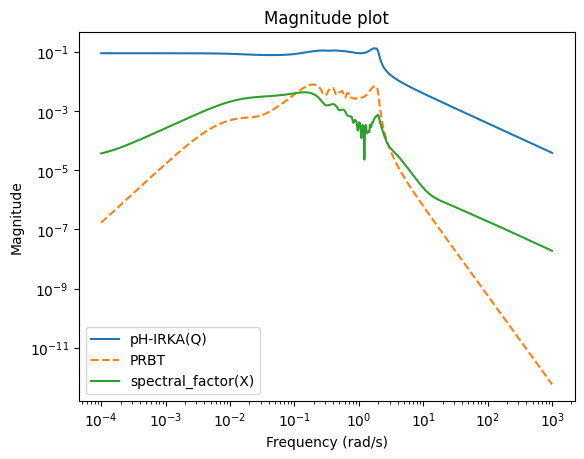

In [16]:
import matplotlib.pyplot as plt
w = (1e-4, 1e3)
fig, ax = plt.subplots()
err1.transfer_function.mag_plot(w, ax=ax, label='pH-IRKA(Q)')
err2.transfer_function.mag_plot(w, ax=ax, linestyle='--', label='PRBT')
err3.transfer_function.mag_plot(w, ax=ax, label='spectral_factor(X)')
_ = ax.legend()

# pH-IRKA with positive-real observability Gramian as $Q$

In [17]:
fom_X = PHLTIModel.from_passive_LTIModel(fom)

Note that this might destroy the sparsity of $J,R$ and $Q$!

In [18]:
reductor = PHIRKAReductor(fom_X)
rom4 = reductor.reduce(10)

00:02 PHIRKAReductor: Generating initial interpolation data
00:02 PHIRKAReductor: Starting pH-IRKA
00:02 gram_schmidt: Orthonormalizing vector 2 again
00:02 gram_schmidt: Orthonormalizing vector 3 again
00:02 gram_schmidt: Orthonormalizing vector 4 again
00:02 gram_schmidt: Orthonormalizing vector 5 again
00:02 gram_schmidt: Orthonormalizing vector 6 again
00:02 gram_schmidt: Orthonormalizing vector 7 again
00:02 gram_schmidt: Orthonormalizing vector 8 again
00:02 gram_schmidt: Orthonormalizing vector 9 again
00:02 PHLTIPGReductor: Operator projection ...
00:02 PHLTIPGReductor: Building ROM ...
00:02 PHIRKAReductor: Convergence criterion in iteration 1: 1.871635e+01
00:02 gram_schmidt: Orthonormalizing vector 2 again
00:02 gram_schmidt: Orthonormalizing vector 3 again
00:02 gram_schmidt: Orthonormalizing vector 4 again
00:02 gram_schmidt: Orthonormalizing vector 5 again
00:02 gram_schmidt: Orthonormalizing vector 6 again
00:02 gram_schmidt: Orthonormalizing vector 7 again
00:02 gram_sc

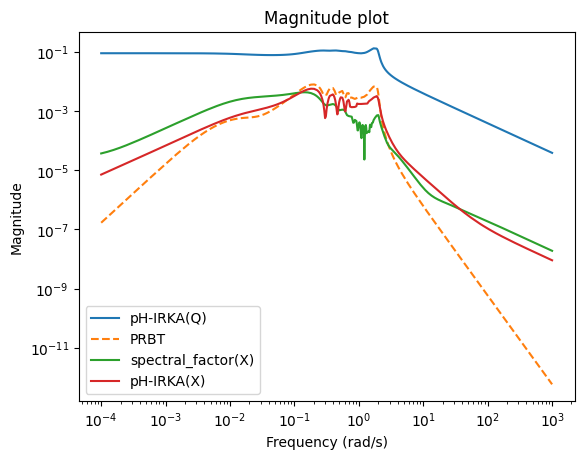

In [19]:
err4 = fom - rom4

fig, ax = plt.subplots()
err1.transfer_function.mag_plot(w, ax=ax, label='pH-IRKA(Q)')
err2.transfer_function.mag_plot(w, ax=ax, linestyle='--', label='PRBT')
err3.transfer_function.mag_plot(w, ax=ax, label='spectral_factor(X)')
err4.transfer_function.mag_plot(w, ax=ax, label='pH-IRKA(X)')
_ = ax.legend()

# Literature

- A. C. Antoulas. Approximation of Large-Scale Dynamical Systems. Volume 6 of Adv. Des. Control. SIAM Publications, Philadelphia, PA, 2005. ISBN 9780898715293.
- [BU22] T. Breiten and B. Unger. Passivity preserving model reduction via spectral factorization.
Automatica, 142:110368, 2022.
- K. Cherifi, H. Gernandt, and D. Hinsen. The difference between port-Hamiltonian, passive
and positive real descriptor systems, preprint, 2022.
- [GPBvandSchaft12] S. Gugercin, Rostyslav V. Polyuga, C. Beattie, and A. van der Schaft. Structure-preserving tangential interpolation for model reduction of port-Hamiltonian systems. Automatica, 48(9):1963–1974, 2012.
- [DP84] U. Desai and D. Pal. A transformation approach to stochastic model reduction. IEEE Transactions on Automatic Control, 29(12):1097–1100, 1984.
- [GA04] S. Gugercin and A. C. Antoulas. A survey of model reduction by balanced truncation and some new results. International Journal of Control, 77(8):748–766, 2004.
- [HJS84] P. Harshavardhana, E.A. Jonckheere, and L.M. Silverman. Stochastic balancing and approximation-stability and minimality. IEEE Transactions on Automatic Control, 29(8):744–746, 1984.